# Define the system  

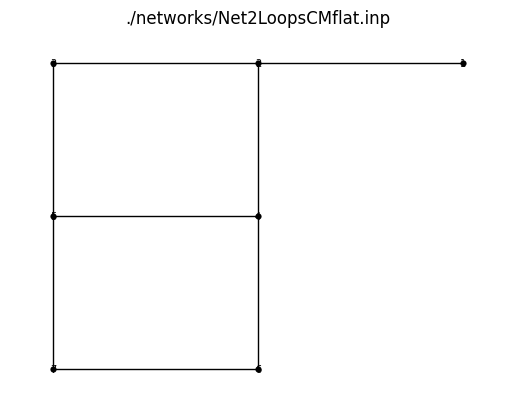

<Axes: title={'center': './networks/Net2LoopsCMflat.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
# inp_file = './networks/Net0.inp'
inp_file = './networks/Net2LoopsDWflat.inp'
inp_file = './networks/Net2LoopsCMflat.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

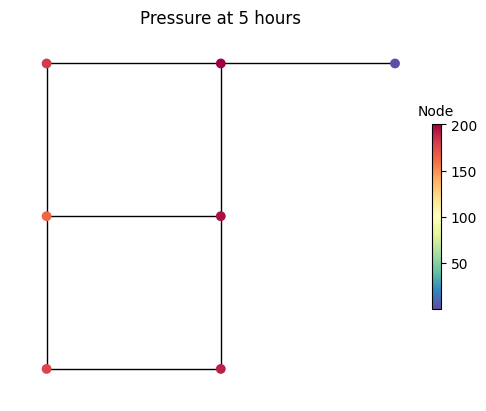

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
ref_pressure = results.node['pressure'].values[0]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 3.111e-01,  5.111e-02,  2.322e-01,  3.108e-02,  1.678e-01,  7.613e-02,  2.334e-02, -2.058e-02,  2.007e+02,  1.817e+02,  1.956e+02,  1.638e+02,  1.905e+02,  1.778e+02,  4.395e-07], dtype=float32)

## Run with the QUBO Polynomial Solver

In [4]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [5]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 7
step = (15/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

nqbit = 7
step = (500/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+500.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 500.000000 => 1000.000000 (res: 3.937008)
Flow Encoding : -15.000000 => -0.000000 | 0.000000 => 15.000000 (res: 0.118110)


Solve the system classically

In [6]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, bin_rep_sol, cvgd = net.classical_solutions()
ref_sol / ref_values[:-1]

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.999, 1.   , 1.001, 1.   , 1.001, 1.   , 1.001])

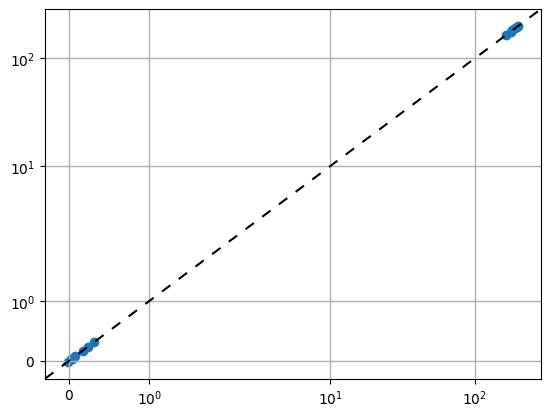

In [7]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol)
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

## Own sampler

In [8]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo

model, model_updater = create_hydraulic_model_for_qubo(wn)
net.matrices = net.initialize_matrices(model)

In [9]:
from wntr_quantum.sampler.simulated_annealing import SimulatedAnnealing
sampler = SimulatedAnnealing()

In [10]:
from qubops.qubops_mixed_vars import QUBOPS_MIXED
import sparse
net.qubo = QUBOPS_MIXED(net.mixed_solution_vector, {"sampler": sampler})
matrices = tuple(sparse.COO(m) for m in net.matrices)
net.qubo.qubo_dict = net.qubo.create_bqm(matrices, strength=1E7)

In [11]:
from wntr_quantum.sampler.step.full_random import RandomStep
var_names = sorted(net.qubo.qubo_dict.variables)
net.qubo.create_variables_mapping()
mystep = RandomStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables)

In [12]:
# from wntr_quantum.sampler.step.full_random import IncrementalStep
# mystep = IncrementalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables, step_size=10)

In [13]:
from wntr_quantum.sampler.simulated_annealing import generate_random_valid_sample
x = generate_random_valid_sample(net.qubo)
x0 = list(x.values())

In [14]:
def flatten_list(lst):
    out = []
    for elmt in lst:
        if not isinstance(elmt, list):
            out += [elmt]
        else:
            out += elmt
    return out

from copy import deepcopy
mod_bin_rep_sol = deepcopy(bin_rep_sol)

for i in range(16,22):
    mod_bin_rep_sol[i] = list(np.random.randint(2, size=7))
x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
x0 = list(x.values())


In [15]:
mod_bin_rep_sol

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 [1, 0, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 1],
 [1, 0, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 1, 1, 0],
 [1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 1],
 [0, 1, 0, 0, 1, 0, 0],
 [0, 1, 1, 1, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0]]

In [16]:
num_sweeps = 10000
Tinit = 1E5
Tfinal = 1E0
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))

In [17]:
res = sampler.sample(net.qubo.qubo_dict, x0=x0, Tschedule=Tschedule, take_step=mystep, save_traj=True)

  0%|          | 0/11000 [00:00<?, ?it/s]

100%|██████████| 11000/11000 [00:57<00:00, 192.32it/s]


In [18]:
mystep.verify_quadratic_constraints(res.res)

In [19]:
eref = net.qubo.energy_binary_rep(bin_rep_sol)

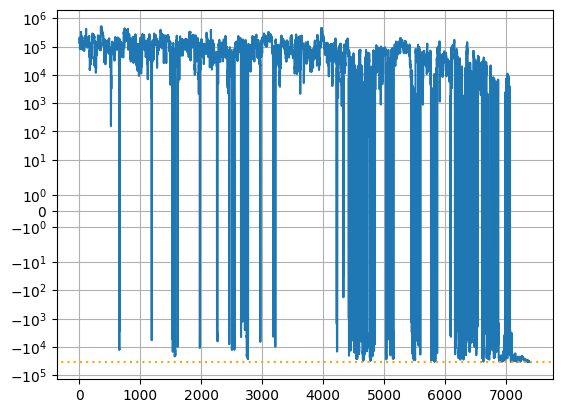

In [20]:
import matplotlib.pyplot as plt
eplt = res.energies #[:100]
plt.plot(eplt)
plt.axline((0, eref[0]), slope=0, color="orange", linestyle=(1, (1, 2)))
plt.grid()
plt.yscale('symlog')

In [21]:
sol = net.qubo.decode_solution(np.array(res.res))
sol = net.combine_flow_values(sol)
sol = net.convert_solution_to_si(sol)

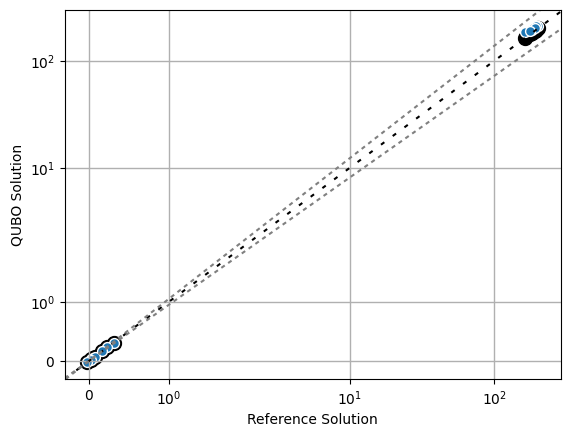

In [25]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')
plt.scatter(ref_values[:-1], sol, s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
# plt.legend()
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

In [23]:
traj = []
for x in res.trajectory:
    sol = net.qubo.decode_solution(np.array(x))
    sol = net.combine_flow_values(sol)
    sol = net.convert_solution_to_si(sol)
    traj.append(sol)

Text(0, 0.5, 'QUBO Solution')

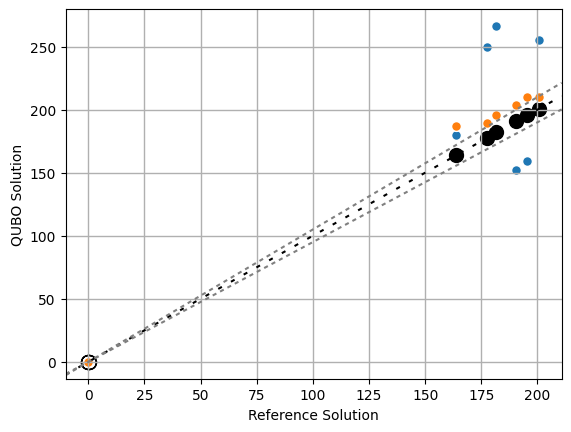

In [24]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')

plt.scatter(ref_values[:-1], traj[0], s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.scatter(ref_values[:-1], traj[-1], s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')